<a href="https://colab.research.google.com/github/svasylyeva/AWS/blob/main/Code_128px_35_folders_FINAL_night.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/svasylyeva/AWS/blob/main/Code_128px_35_folders_FINAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Importing the Keras libraries and packages
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers.core import Dense, Dropout, Activation, Flatten

from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import tensorflow
from sklearn.metrics import classification_report, confusion_matrix
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
from numpy.random import seed
import os
from shutil import copy2
from tqdm import tqdm
from PIL import Image
import PIL
import random
from keras.optimizers import Adam
from keras.layers.normalization import BatchNormalization 

# import splitfolders library to split folder with chosen ratio
import splitfolders
import matplotlib.pyplot as plt
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import Model
from matplotlib import pyplot
from numpy import expand_dims

<h3>Pre-processing Part</h3>


In [ ]:
# Pre-processing Part
# Copy files from a set of folders inside downloaded artist to one folder for every artist

# Wikiart script downloads files to the local drive
root_dir = '/Users/murmu/Documents/Deep_Learning/wikiart/wikiart-master/wikiart-saved/images/'
destination_dir = '/Users/murmu/Documents/Deep_Learning/wikiart/wikiart-master/artists/'

# Download pictures with wikiart code from WikiArt and create folders with chosen artists
# link to github project - https://github.com/lucasdavid/wikiart
# We do not show code of the script for downloading here - it could be found on the link above

# Folders of artist after wikiart work
src_artist_lst = [ 'camille-pissarro', 'claude-monet', 
                  'henri-matisse', 'pierre-auguste-renoir', 'vincent-van-gogh', 'john-singer-sargent']

# Folders of artists that we are going to use in the further work
dest_artist_lst = ['Pissaro', 'Monet', 'Matisse', 'Renoir', 'VanGogh', 'Sargent']

# Define function to copy jpegs from folders that wikiart script created on local drive
def copy_jpegs(src_artist, dest_artist):
# Define source and destination directories
    artist_src_dir = os.path.join(root_dir, src_artist)
    artist_destination_dir = os.path.join(destination_dir, dest_artist)

# Copy files from all directories inside main directory with the name of artist
# showing progress bar of the process
    for root, dirs, files in os.walk(artist_src_dir):
        for file in tqdm(files):
            path_file = os.path.join(root, file)
            source_resized_file = os.path.join(artist_destination_dir, file)

# To resize our files and avoid stretching for rectangular files we used AlexNet pre-processing approach:
# - down-sample the images to a fixed resolution of 256 × 256
# - for rectangular image, we first rescaled the image such that the shorter side was of length 256 and
# cropped out the central 256×256 part from the resulting image
            max_side = 256
            image = Image.open(path_file)
            w, h = image.size
            original_size = max(w, h)

            # If image has a rectangular shape - resize it such way 
            # that the shortest side of the image becomes 256px and crop the center
            if (w < h):
                resized_width = max_side
                resized_height = int(round((max_side/float(image.size[0]))*image.size[1]))
                # resixe image
                image = image.resize((resized_width, resized_height), Image.ANTIALIAS)
                left = 0
                top = (resized_height - max_side)/2
                right = max_side
                bottom = (resized_height + max_side)/2
                image = image.crop((left, top, right, bottom))
            else:
                resized_height = max_side
                resized_width = int(round((max_side/float(image.size[1]))*image.size[0]))
                # resixe image
                image = image.resize((resized_width, resized_height), Image.ANTIALIAS)
                left = (resized_width - max_side)/2
                top = 0
                right = (resized_width + max_side)/2
                bottom = max_side
                image = image.crop((left, top, right, bottom))
            
            # convert to RGB incase it's RGBA
            cropped_rgb_image = image.convert("RGB")
            # save resized image
            cropped_rgb_image.save(source_resized_file, image.format)

        
# Create a zip list 
zip_lst = list(zip(src_artist_lst, dest_artist_lst))

# copy files
for (src, dest) in zip_lst: 
    copy_jpegs(src, dest)

0it [00:00, ?it/s]
100%|██████████| 71/71 [00:02<00:00, 32.26it/s]
0it [00:00, ?it/s]
100%|██████████| 9/9 [00:00<00:00, 32.94it/s]
0it [00:00, ?it/s]
100%|██████████| 32/32 [00:01<00:00, 17.17it/s]
0it [00:00, ?it/s]
100%|██████████| 249/249 [00:08<00:00, 30.90it/s]
0it [00:00, ?it/s]
100%|██████████| 238/238 [00:11<00:00, 20.67it/s]
0it [00:00, ?it/s]
100%|██████████| 45/45 [00:00<00:00, 61.50it/s]


In [3]:
# We begin to work with images of size 128*128px for 30 epochs
# for our baseline models
img_rows = 128
img_cols = 128
epochs = 30
batch_size = 64

In [4]:
# Plot diagnostic learning curves from history
def graph_accuracy_loss(history):
    pyplot.figure(figsize=(10,5))
    # Plot loss
    pyplot.subplot(121)
    pyplot.title('Entropy Loss')
    pyplot.plot(history.history['loss'], color='green', label='train')
    pyplot.plot(history.history['val_loss'], color='blue', label='test')
    pyplot.legend()
    # Plot accuracy
    pyplot.subplot(122)
    pyplot.title('\nClassification Accuracy')
    pyplot.plot(history.history['accuracy'], color='green', label='train')
    pyplot.plot(history.history['val_accuracy'], color='blue', label='test')
    pyplot.legend()
    # Show plot
    pyplot.show()

In [5]:
# Function that calculates Confusion Matrix and shows Classification Report
def class_report(test_set, model):
# Predict with our model
    Y_pred = model.predict(test_set, num_of_test_samples // batch_size + 1)
    y_pred = np.argmax(Y_pred, axis=1)
    print('Confusion Matrix')
# Use confusion_matrix from sklearn
    print(confusion_matrix(test_set.classes, y_pred))
    print('Classification Report')
    target_names = list(training_set.class_indices.keys())
    print(classification_report(test_set.classes, y_pred, target_names=target_names))

In [ ]:
# Function that calculates Confusion Matrix and shows Classification Report
def confusion_chart(test_set, model):
# Predict with our model
    Y_pred = model.predict(test_set, num_of_test_samples // batch_size + 1)
    y_pred = np.argmax(Y_pred, axis=1)
    cm = confusion_matrix(test_set.classes, y_pred))
    # add a subplot
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cm_norm = conf_mat.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    # Plot the matrix
    cax = ax.matshow(cm_norm)

    # add colorbar for reference
    fig.colorbar(cax)

    # add labels to plot
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

In [ ]:
# Import and work with splitfolders 
#link - https://pypi.org/project/split-folders/

# Divide all artists folders to train and val folders
# Folder 'artists' could be downloaded from github - https://github.com/Doyun-Shin/DL-Artist-Recognition
splitfolders.ratio("./artists", output="./", seed=42 , ratio=(.7, .3))

In [11]:
# Prepare the data. Instanciate ImageDataGenerator that generates batches of image data 
# scaling the pixel values to the range of 0-1.
# We don't use data augmentation, dropout etc for the Baseline models to check a minimal model performance 
datagen = ImageDataGenerator(rescale=1. / 255)

# Use train folder that was created with splitfolders for creating training set
training_set = datagen.flow_from_directory('train', 
                                                 target_size=(img_rows, img_cols),
                                                 batch_size=batch_size,
                                                 class_mode='categorical')

# Use val folder that was created with splitfolders for creating validation set
test_set = datagen.flow_from_directory('val',
                                            target_size=(img_rows, img_cols),
                                            batch_size=batch_size, shuffle = False,
                                            class_mode='categorical')

Found 3360 images belonging to 6 classes.
Found 1440 images belonging to 6 classes.


In [12]:
# Define number of samnples for train and test sets
num_of_train_samples = training_set.n
num_of_test_samples = test_set.n

In [13]:
# Print our classes 
print(test_set.class_indices)

{'Matisse': 0, 'Monet': 1, 'Pissaro': 2, 'Renoir': 3, 'Sargent': 4, 'VanGogh': 5}


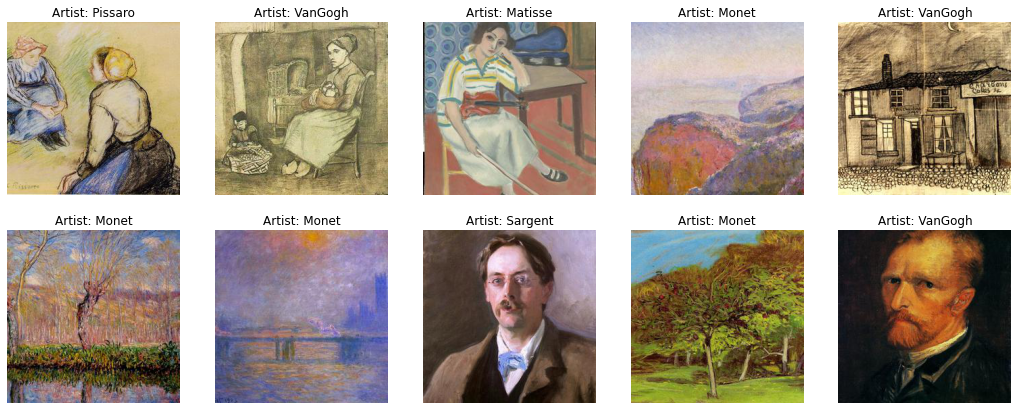

In [22]:
# Folder 'artists' could be downloaded from github - https://github.com/Doyun-Shin/DL-Artist-Recognition
# Define the list with artists names
artists_name = os.listdir('artists')

# Plot 10 random paintings
rows = 2
cols = 5
fig, axes = plt.subplots(figsize=(18,7))
axes=[]
for i in range(rows*cols):
    axes.append( fig.add_subplot(rows, cols, i+1) )
    random_artist = random.choice(artists_name)
    random_image = random.choice(os.listdir(os.path.join('artists', random_artist)))
    random_image_file = os.path.join('artists', random_artist, random_image)
    image = plt.imread(random_image_file)
    ax = pyplot.subplot(rows, cols, i+1)
    axes[i].imshow(image)
    axes[i].set_title("Artist: " + random_artist.replace('_', ' '))
    axes[i].axis('off')
    axes[i].axis('off')

plt.show()

In [ ]:
# VGG Blocks
# One VGG block consists of a sequence of convolutional layers, followed by a max pooling layer for spatial downsampling. 
# The authors employed convolutions with  3×3  kernels with padding of 1 (keeping height and width) 
# and  2×2  max pooling with stride of 2 (halving the resolution after each block). 

<h3>Baseline model with 1 VGG block without dropout</h3>


In [23]:
# Part 1 - Develop a Baseline CNN Models:
# Define CNN model with one VGG-style block
# The 1-block VGG model has a single convolutional layer with 32 filters 
# followed by a max pooling layer
def baseline_model_1():
    
    model = Sequential()
# Add two 2D convolution layers with 32 filters. 
# Each Conv2D layer will have the ReLU activation and the “he_uniform” weight initialization (generally best practices)
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', 
                     input_shape=(img_rows, img_cols, 3)))
    model.add(Conv2D(32,(3,3), activation = 'relu', kernel_initializer = 'he_uniform', padding = 'same'))
# Add MaxPooling layer for downsampling
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    
    model.add(Flatten())
# Fully-connected layers
    model.add(Dense(128, activation='relu', 
                    kernel_initializer='he_uniform'))
    model.add(Dense(6, activation='softmax'))
    
# Compilation of a model    
# The model will be optimized using stochastic gradient descent. 
# with a learning rate of 0.001 and a momentum of 0.9. 
    opt = SGD(lr=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [24]:
# The model will be fit for 30 epochs - to check model's accuracy
# Define model
model = baseline_model_1()
# Fit model
history = model.fit_generator(training_set, 
                              steps_per_epoch=len(training_set), # = num_of_train_samples // batch_size +1
                              validation_data=test_set, 
                              validation_steps=len(test_set), # = num_of_test_samples // batch_size +1
                              epochs= epochs)

Epoch 1/30
53/53 [==============================] - 41s 147ms/step - loss: 2.1737 - accuracy: 0.2201 - val_loss: 1.6074 - val_accuracy: 0.3521
Epoch 2/30
53/53 [==============================] - 7s 136ms/step - loss: 1.5568 - accuracy: 0.3742 - val_loss: 1.4725 - val_accuracy: 0.4382
Epoch 3/30
53/53 [==============================] - 7s 139ms/step - loss: 1.4259 - accuracy: 0.4671 - val_loss: 1.3894 - val_accuracy: 0.4861
Epoch 4/30
53/53 [==============================] - 7s 139ms/step - loss: 1.3459 - accuracy: 0.5087 - val_loss: 1.3544 - val_accuracy: 0.4847
Epoch 5/30
53/53 [==============================] - 7s 139ms/step - loss: 1.2727 - accuracy: 0.5252 - val_loss: 1.3353 - val_accuracy: 0.4951
Epoch 6/30
53/53 [==============================] - 7s 139ms/step - loss: 1.1741 - accuracy: 0.5759 - val_loss: 1.3230 - val_accuracy: 0.5243
Epoch 7/30
53/53 [==============================] - 7s 139ms/step - loss: 1.1277 - accuracy: 0.5980 - val_loss: 1.3600 - val_accuracy: 0.4694
Epoch

In [25]:
# Evaluate model
_, acc = model.evaluate_generator(test_set, steps=len(test_set), verbose=0)
print("Accuracy: %.4f" % (acc * 100.0))

Accuracy: 51.2500


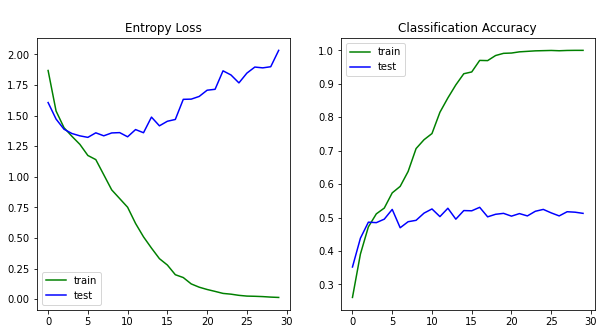

In [26]:
# Build graphs of entropy loss and accuracy
graph_accuracy_loss(history)

In [27]:
# Build a classification report
class_report(test_set, model)

Confusion Matrix
[[ 94  22  35  28  24  37]
 [  7 119  60  10  10  34]
 [  6  19 163  17   8  27]
 [  9  11  34 130  25  31]
 [ 17  21  40  25 113  24]
 [  6  16  57  24  18 119]]
Classification Report
              precision    recall  f1-score   support

     Matisse       0.68      0.39      0.50       240
       Monet       0.57      0.50      0.53       240
     Pissaro       0.42      0.68      0.52       240
      Renoir       0.56      0.54      0.55       240
     Sargent       0.57      0.47      0.52       240
     VanGogh       0.44      0.50      0.46       240

    accuracy                           0.51      1440
   macro avg       0.54      0.51      0.51      1440
weighted avg       0.54      0.51      0.51      1440



In [ ]:
# As we see our 1-vgg block model is over-fitting on a training set

In [28]:
# Check model summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 131072)            0         
_________________________________________________________________
dense (Dense)                (None, 128)               16777344  
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 774       
Total params: 16,788,262
Trainable params: 16,788,262
Non-trainable params: 0
____________________________________________

<h3>Baseline model with 2 VGG blocks without dropout</h3>


In [29]:
# Define CNN model with two VGG-style blocks according to the principle explained earlier
def baseline_model_2():
   # reset_random_seeds()
    model = Sequential()
# 1st block    
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', 
                     input_shape=(img_rows, img_cols, 3)))
    model.add(Conv2D(32,(3,3), activation = 'relu', kernel_initializer = 'he_uniform', padding = 'same'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

# 2d block    
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(64,(3,3), activation = 'relu', kernel_initializer = 'he_uniform', padding = 'same'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
   
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(6, activation='softmax'))
# Compilation of a model
    opt = SGD(lr=0.001, momentum=0.9) # Gradient descent (with momentum) optimizer.
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [30]:
# The model will be fit for 30 epochs 
# define model
model = baseline_model_2()
# fit model
history = model.fit_generator(training_set, steps_per_epoch=len(training_set),
                              validation_data=test_set, 
                              validation_steps=len(test_set), 
                              epochs= epochs)

Epoch 1/30
53/53 [==============================] - 9s 155ms/step - loss: 2.1001 - accuracy: 0.2050 - val_loss: 1.6430 - val_accuracy: 0.3319
Epoch 2/30
53/53 [==============================] - 8s 142ms/step - loss: 1.6252 - accuracy: 0.3665 - val_loss: 1.5402 - val_accuracy: 0.4201
Epoch 3/30
53/53 [==============================] - 8s 143ms/step - loss: 1.4945 - accuracy: 0.4388 - val_loss: 1.4450 - val_accuracy: 0.4549
Epoch 4/30
53/53 [==============================] - 8s 143ms/step - loss: 1.3969 - accuracy: 0.4901 - val_loss: 1.4595 - val_accuracy: 0.4854
Epoch 5/30
53/53 [==============================] - 8s 141ms/step - loss: 1.3718 - accuracy: 0.4635 - val_loss: 1.3745 - val_accuracy: 0.5042
Epoch 6/30
53/53 [==============================] - 8s 142ms/step - loss: 1.2812 - accuracy: 0.5319 - val_loss: 1.3169 - val_accuracy: 0.5097
Epoch 7/30
53/53 [==============================] - 8s 142ms/step - loss: 1.1985 - accuracy: 0.5498 - val_loss: 1.3839 - val_accuracy: 0.4701
Epoch 

In [31]:
# Evaluate model
_, acc = model.evaluate_generator(test_set, steps=len(test_set), verbose=0)
print("Accuracy: %.4f" % (acc * 100.0))

Accuracy: 52.5694


In [34]:
# Build a classification report
class_report(test_set, model)

Confusion Matrix
[[133  16  14  25  23  29]
 [ 14 120  47  11  20  28]
 [ 16  23 131  28  13  29]
 [ 17   7  20 139  29  28]
 [ 35   8  33  31 116  17]
 [ 17  16  42  31  16 118]]
Classification Report
              precision    recall  f1-score   support

     Matisse       0.57      0.55      0.56       240
       Monet       0.63      0.50      0.56       240
     Pissaro       0.46      0.55      0.50       240
      Renoir       0.52      0.58      0.55       240
     Sargent       0.53      0.48      0.51       240
     VanGogh       0.47      0.49      0.48       240

    accuracy                           0.53      1440
   macro avg       0.53      0.53      0.53      1440
weighted avg       0.53      0.53      0.53      1440



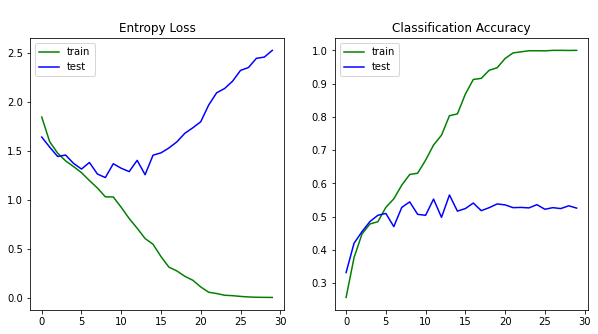

In [35]:
# Build graphs of entropy loss and accuracy
graph_accuracy_loss(history)

In [36]:
# As we see our 2-vgg block model is over-fitting on a training set as well

<h3>Baseline model with 3 VGG blocks without dropout</h3>


In [37]:
# Define CNN model with three VGG-style blocks according to the principle explained earlier
def baseline_model_3():
    #reset_random_seeds()
    model = Sequential()
# 1st block    
    model.add(Conv2D(32, (3, 3), activation='relu', 
                     kernel_initializer='he_uniform', 
                     padding='same', input_shape=(img_rows, img_cols, 3)))
    model.add(Conv2D(32,(3,3), activation = 'relu', kernel_initializer = 'he_uniform', padding = 'same'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
# 2d block    
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(64,(3,3), activation = 'relu', kernel_initializer = 'he_uniform', padding = 'same'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
# 3d block
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(128,(3,3), activation = 'relu', kernel_initializer = 'he_uniform', padding = 'same'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
   
    model.add(Flatten())
    model.add(Dense(128, activation='relu', 
                    kernel_initializer='he_uniform'))
    model.add(Dense(6, activation='softmax'))
# Compilation of a model
    opt = SGD(lr=0.001, momentum=0.9) # Gradient descent (with momentum) optimizer.
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [39]:
# The model will be fit for 30 epochs 
# Define model
model = baseline_model_3()
# Fit model
history = model.fit_generator(training_set, steps_per_epoch=len(training_set),
                              validation_data=test_set, 
                              validation_steps=len(test_set), 
                              epochs= epochs)

Epoch 1/30
53/53 [==============================] - 9s 152ms/step - loss: 1.7303 - accuracy: 0.2561 - val_loss: 1.4819 - val_accuracy: 0.4507
Epoch 2/30
53/53 [==============================] - 8s 147ms/step - loss: 1.4704 - accuracy: 0.4436 - val_loss: 1.5360 - val_accuracy: 0.4250
Epoch 3/30
53/53 [==============================] - 8s 150ms/step - loss: 1.3980 - accuracy: 0.4681 - val_loss: 1.3657 - val_accuracy: 0.4826
Epoch 4/30
53/53 [==============================] - 8s 150ms/step - loss: 1.2609 - accuracy: 0.5317 - val_loss: 1.2968 - val_accuracy: 0.5139
Epoch 5/30
53/53 [==============================] - 8s 149ms/step - loss: 1.1853 - accuracy: 0.5635 - val_loss: 1.4524 - val_accuracy: 0.4507
Epoch 6/30
53/53 [==============================] - 8s 150ms/step - loss: 1.1843 - accuracy: 0.5456 - val_loss: 1.3184 - val_accuracy: 0.5056
Epoch 7/30
53/53 [==============================] - 8s 148ms/step - loss: 1.0426 - accuracy: 0.6222 - val_loss: 1.2173 - val_accuracy: 0.5542
Epoch 

In [40]:
# Evaluate model
_, acc = model.evaluate_generator(test_set, steps=len(test_set), verbose=0)
print("Accuracy: %.4f" % (acc * 100.0))

Accuracy: 56.4583


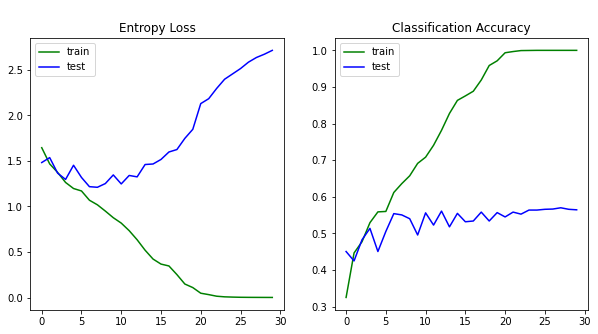

In [41]:
# Build graphs of entropy loss and accuracy
graph_accuracy_loss(history)

In [42]:
# Build a classification report
class_report(test_set, model)

Confusion Matrix
[[129  20  12  24  31  24]
 [ 12 145  37   7  11  28]
 [ 10  26 133  12  12  47]
 [ 16  17  19 140  23  25]
 [ 29  11  20  28 126  26]
 [ 10  17  35  19  19 140]]
Classification Report
              precision    recall  f1-score   support

     Matisse       0.63      0.54      0.58       240
       Monet       0.61      0.60      0.61       240
     Pissaro       0.52      0.55      0.54       240
      Renoir       0.61      0.58      0.60       240
     Sargent       0.57      0.53      0.55       240
     VanGogh       0.48      0.58      0.53       240

    accuracy                           0.56      1440
   macro avg       0.57      0.56      0.57      1440
weighted avg       0.57      0.56      0.57      1440



In [ ]:
# Accuracy score for 3 VGG blocks is higher than for 2 vgg blcoks model, 
# so we will continiue with it.
# We still have an over-fitting so we will add a dropout regularizatiom

In [ ]:
# Part 2 - Add Dropout Regularization and Data Augmentation
# to our Baseline model step by step and evaluate an efficiency  
# ___________________________________________________________


# 1 step - Add Dropout

<h3>Model with 3 VGG blocks with dropout</h3>

In [43]:
# Prepare the data. Instanciate ImageDataGenerator that scalse the pixel values to the range of 0-1
# We don't use data augmentation for this moment 
datagen = ImageDataGenerator(rescale=1. / 255)

training_set = datagen.flow_from_directory('train', target_size=(img_rows, img_cols),
                                                 batch_size=batch_size,
                                                 class_mode='categorical')

test_set = datagen.flow_from_directory('val',target_size=(img_rows, img_cols),
                                            batch_size=batch_size, shuffle = False,
                                            class_mode='categorical')

Found 3360 images belonging to 6 classes.
Found 1440 images belonging to 6 classes.


In [44]:
# Define CNN model with Dropout Regularization using 3 VGG blocks model
def model_with_dropout():
    model = Sequential()
   
    # 1st block    
    model.add(Conv2D(32, (3, 3), activation='relu', 
                     kernel_initializer='he_uniform', 
                     padding='same', input_shape=(img_rows, img_cols, 3)))
    model.add(Conv2D(32,(3,3), activation = 'relu', kernel_initializer = 'he_uniform', padding = 'same'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    
# 2d block    
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(64,(3,3), activation = 'relu', kernel_initializer = 'he_uniform', padding = 'same'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    
# 3d block
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(128,(3,3), activation = 'relu', kernel_initializer = 'he_uniform', padding = 'same'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
   
    model.add(Flatten())
    model.add(Dense(128, activation='relu', 
                    kernel_initializer='he_uniform'))
# Dropout 0.5 was added meaning that 50% of the nodes will be ignored
    model.add(Dropout(0.5))
    model.add(Dense(6, activation='softmax'))
    # Compilation of a model
    opt = SGD(lr=0.001, momentum=0.9) # Gradient descent (with momentum) optimizer.
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [45]:
# The model will be fit for 30 epochs 
# Define model
model_d = model_with_dropout()
# Fit model
history = model_d.fit_generator(training_set, steps_per_epoch=len(training_set),
                                validation_data=test_set,
                                validation_steps=len(test_set), 
                                epochs= epochs)

Epoch 1/30
53/53 [==============================] - 9s 153ms/step - loss: 2.0280 - accuracy: 0.1807 - val_loss: 1.7275 - val_accuracy: 0.3194
Epoch 2/30
53/53 [==============================] - 8s 149ms/step - loss: 1.7295 - accuracy: 0.2642 - val_loss: 1.6299 - val_accuracy: 0.3917
Epoch 3/30
53/53 [==============================] - 8s 147ms/step - loss: 1.6466 - accuracy: 0.3281 - val_loss: 1.5002 - val_accuracy: 0.4563
Epoch 4/30
53/53 [==============================] - 8s 147ms/step - loss: 1.5481 - accuracy: 0.3949 - val_loss: 1.4267 - val_accuracy: 0.4701
Epoch 5/30
53/53 [==============================] - 8s 147ms/step - loss: 1.4869 - accuracy: 0.4150 - val_loss: 1.4255 - val_accuracy: 0.4771
Epoch 6/30
53/53 [==============================] - 8s 147ms/step - loss: 1.5042 - accuracy: 0.4158 - val_loss: 1.3693 - val_accuracy: 0.4722
Epoch 7/30
53/53 [==============================] - 8s 148ms/step - loss: 1.4647 - accuracy: 0.4311 - val_loss: 1.3455 - val_accuracy: 0.4806
Epoch 

In [46]:
# Evaluate model
_, acc = model_d.evaluate_generator(test_set, steps=len(test_set), verbose=0)
print("Accuracy: %.4f" % (acc * 100.0))

Accuracy: 59.7917


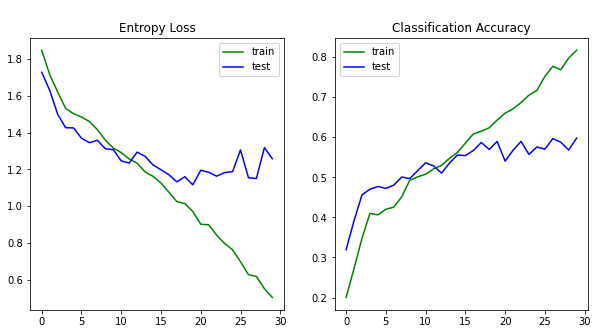

In [47]:
# Build graphs of entropy loss and accuracy
graph_accuracy_loss(history)

In [ ]:
# As we see model overfitts less after usage of dropout

In [48]:
# Build a classification report
class_report(test_set, model_d)

Confusion Matrix
[[138  26   9  24  36   7]
 [  8 152  36   9  23  12]
 [ 11  30 158  13  19   9]
 [  9  13  19 150  40   9]
 [ 22  10  18  17 168   5]
 [  9  37  45  20  34  95]]
Classification Report
              precision    recall  f1-score   support

     Matisse       0.70      0.57      0.63       240
       Monet       0.57      0.63      0.60       240
     Pissaro       0.55      0.66      0.60       240
      Renoir       0.64      0.62      0.63       240
     Sargent       0.53      0.70      0.60       240
     VanGogh       0.69      0.40      0.50       240

    accuracy                           0.60      1440
   macro avg       0.61      0.60      0.60      1440
weighted avg       0.61      0.60      0.60      1440



In [49]:
# Check model summary
model_d.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 128, 128, 32)      896       
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 128, 128, 32)      9248      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 64, 64, 64)        18496     
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 64, 64, 64)        36928     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 32, 32, 128)      

In [ ]:
# 2 step - Add Data augmentation
# Use our 3 VGG blocks model with dropout

<h3>Model with 3 VGG blocks with dropout and data augmentation</h3>


<h4>Trained for max 85 epochs with dropout and data augmentation (with Early Stopping and saving the best model)</h4>


In [66]:
# Implementing Early stoping and checkpoint to save the model with the highest accuracy
ES = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
# Save chekpoints to best_model.h5
MC = ModelCheckpoint('best_model.h5', monitor='val_accuracy', verbose=1, save_best_only=True, 
                     save_weights_only=False, mode='auto')

In [67]:
# Before implementing data augmentation, will look how its afect the image

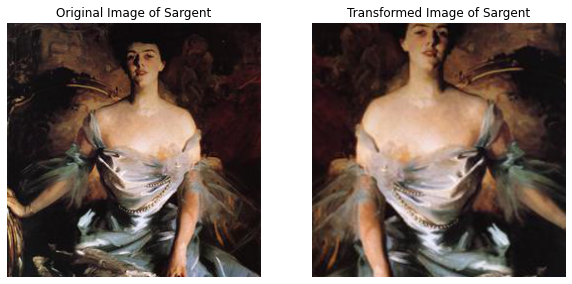

In [71]:
# Print a random paintings and augmented version
fig, axes = plt.subplots(1, 2, figsize=(10,10))

# Select a random artist
random_artist = random.choice(artists_name)
# Select a random image with selected random artist
random_image = random.choice(os.listdir(os.path.join('train', random_artist)))
# Get the direction of image file
random_image_file = os.path.join('train', random_artist, random_image)

# Original image
image = plt.imread(random_image_file)
axes[0].imshow(image)
axes[0].set_title("Original Image of " + random_artist.replace('_', ' '))
axes[0].axis('off')

# Transformed image
aug_image = datagen.apply_transform(image,
                                    transform_parameters={#'theta': ,
                                                          #'tx':,
                                                          #'ty': ,
                                                          #'shear': 0.2 ,
                                                          'zx': 0.8,
                                                          'zy': 0.8,
                                                          'flip_horizontal': True,
                                                          #'flip_vertical': True,
                                                          #'channel_shift_intensity': ,
                                                          #'brightness':
                                                         })
axes[1].imshow(aug_image)
axes[1].set_title("Transformed Image of " + random_artist.replace('_', ' '))
axes[1].axis('off')

plt.show()

In [72]:
# Create data generators with data augmentation (different zooming, horizontal flip and shear intensity)
train_datagen = ImageDataGenerator(rescale=1. / 255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')
# We do not use data augmentation for test dataset, only normalize pixels
test_datagen = ImageDataGenerator(rescale=1. / 255)

# Create sets
training_set = train_datagen.flow_from_directory('train',
                                                 target_size=(img_rows, img_cols),
                                                 batch_size=batch_size,
                                                 class_mode='categorical')


test_set = test_datagen.flow_from_directory('val',
                                            target_size=(img_rows, img_cols),
                                            batch_size=batch_size, shuffle = False,
                                            class_mode='categorical')

# Define model
model_dropout_dataaugm = model_with_dropout()
# Fit model for 85 epochs with Early stop
history = model_dropout_dataaugm.fit_generator(training_set, 
                              steps_per_epoch=len(training_set),
                              validation_data=test_set, 
                              validation_steps=len(test_set), 
                              epochs= 85, callbacks=[ES, MC])

Found 3360 images belonging to 6 classes.
Found 1440 images belonging to 6 classes.
Epoch 1/85
53/53 [==============================] - 19s 345ms/step - loss: 2.0400 - accuracy: 0.2144 - val_loss: 1.6283 - val_accuracy: 0.4049

Epoch 00001: val_accuracy improved from -inf to 0.40486, saving model to best_model.h5
Epoch 2/85
53/53 [==============================] - 18s 341ms/step - loss: 1.6555 - accuracy: 0.3401 - val_loss: 1.5370 - val_accuracy: 0.4264

Epoch 00002: val_accuracy improved from 0.40486 to 0.42639, saving model to best_model.h5
Epoch 3/85
53/53 [==============================] - 18s 341ms/step - loss: 1.6001 - accuracy: 0.3699 - val_loss: 1.4560 - val_accuracy: 0.4417

Epoch 00003: val_accuracy improved from 0.42639 to 0.44167, saving model to best_model.h5
Epoch 4/85
53/53 [==============================] - 18s 336ms/step - loss: 1.5380 - accuracy: 0.3951 - val_loss: 1.4567 - val_accuracy: 0.4410

Epoch 00004: val_accuracy did not improve from 0.44167
Epoch 5/85
53/53 [

In [73]:
# Create a new model instance to upload the best saved model there
# because our trained model finished training with the final accuracy not the best possible
model_best = model_with_dropout()


model_best.load_weights('best_model.h5')
# Evaluate model

_, acc = model_best.evaluate_generator(test_set, steps=len(test_set), verbose=0)
print("Best accuracy: %.4f" % (acc * 100.0))

Best accuracy: 63.2639


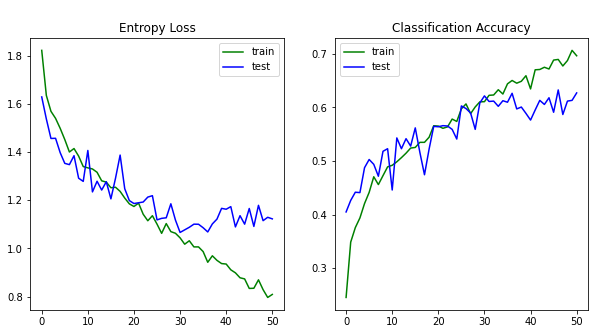

In [74]:
# Build graphs of entropy loss and accuracy
graph_accuracy_loss(history)

<h4>Trained for max 85 epochs and bigger size of pictures (224*224px instead 128*128px) and Early Stopping</h4>

In [78]:
# Implementing Early stoping and checkpoint to save the model with the highest accuracy
ES = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
# Save chekpoints to best_model_224px.h5
MC = ModelCheckpoint('best_model_224px.h5', monitor='val_accuracy', verbose=1, save_best_only=True, 
                     save_weights_only=False, mode='auto')

In [79]:
# Let's try to change pictures size from 128 to 224px and check accuracy
# Create data generators
train_datagen = ImageDataGenerator(rescale=1. / 255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')
test_datagen = ImageDataGenerator(rescale=1. / 255)

img_rows = 224
img_cols = 224
# Create sets
training_set = train_datagen.flow_from_directory('train',
                                                 target_size=(img_rows, img_cols),
                                                 batch_size=batch_size,
                                                 class_mode='categorical')


test_set = test_datagen.flow_from_directory('val',
                                            target_size=(img_rows, img_cols),
                                            batch_size=batch_size, shuffle = False,
                                            class_mode='categorical')

# Define model
model224 = model_with_dropout()
# Fit model for 85 epochs with early stop
history = model224.fit_generator(training_set, 
                              steps_per_epoch=len(training_set),
                              validation_data=test_set, 
                              validation_steps=len(test_set), 
                              epochs= 85, callbacks=[ES, MC])

Found 3360 images belonging to 6 classes.
Found 1440 images belonging to 6 classes.
Epoch 1/85
53/53 [==============================] - 42s 782ms/step - loss: 1.8428 - accuracy: 0.1924 - val_loss: 1.7012 - val_accuracy: 0.2708

Epoch 00001: val_accuracy improved from -inf to 0.27083, saving model to best_model_224px.h5
Epoch 2/85
53/53 [==============================] - 41s 779ms/step - loss: 1.7055 - accuracy: 0.2733 - val_loss: 1.5747 - val_accuracy: 0.4215

Epoch 00002: val_accuracy improved from 0.27083 to 0.42153, saving model to best_model_224px.h5
Epoch 3/85
53/53 [==============================] - 41s 777ms/step - loss: 1.6125 - accuracy: 0.3388 - val_loss: 1.4970 - val_accuracy: 0.4292

Epoch 00003: val_accuracy improved from 0.42153 to 0.42917, saving model to best_model_224px.h5
Epoch 4/85
53/53 [==============================] - 41s 775ms/step - loss: 1.6142 - accuracy: 0.3531 - val_loss: 1.4766 - val_accuracy: 0.4736

Epoch 00004: val_accuracy improved from 0.42917 to 0.47

In [80]:
# Create a new model instance to upload the best saved model there
# because our trained model finished training with the final accuracy not the best possible
model = model_with_dropout()

# Load the previously saved weights
model.load_weights('best_model_224px.h5')
# Evaluate model

_, acc = model.evaluate_generator(test_set, steps=len(test_set), verbose=0)
print("Best accuracy: %.4f" % (acc * 100.0))

Best accuracy: 64.7917


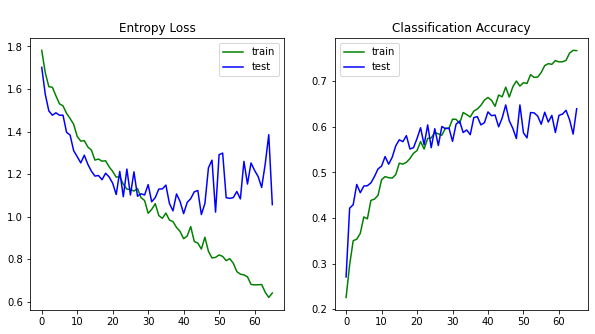

In [81]:
# Build graphs of entropy loss and accuracy
graph_accuracy_loss(history)

In [ ]:
# We achieved higher accuracy with pictures of bigger size (224px instead 128px)
# We will use this trained model as our best one and continue

<h3>Model with 3 VGG blocks, dropout, data augmentation and batch normalization</h3>
<h4>Trained for 85 max epochs and bigger size of pictures (224px) with Early stopping</h4>

In [93]:
# Implementing Early stoping
ES = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience= 20)
# Save chekpoints to 
MC = ModelCheckpoint('best_model_bn.h5', monitor='val_accuracy', 
                     verbose=1, save_best_only=True, save_weights_only=False, mode='auto')

In [94]:
# Let's improve our model's architecture:
# - add batch normalization between layers to speed up training

In [95]:
# Define CNN model with added BatchNormalization
img_rows = 224
img_cols = 224
def model_blocks_bn():
    model = Sequential()
# Batch Normalization added to every block
# 1 block
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(img_rows, img_cols, 3)))
    model.add(BatchNormalization())
    model.add(Conv2D(32,(3,3), activation = 'relu', kernel_initializer = 'he_uniform', padding = 'same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    
# 2 block
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    
# 3 block
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
   
    model.add(Flatten())
    model.add(Dense(128, activation='relu', name='fc1'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(6, activation='softmax', name='output'))
    # Compilation of a model
    opt = SGD(lr=0.001, momentum=0.9) # Gradient descent (with momentum) optimizer.
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [96]:
# Create data generators
train_datagen = ImageDataGenerator(rescale=1. / 255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')
test_datagen = ImageDataGenerator(rescale=1. / 255)

# Create sets
training_set = train_datagen.flow_from_directory('train',
                                                 target_size=(img_rows, img_cols),
                                                 batch_size=batch_size,
                                                 class_mode='categorical')


test_set = test_datagen.flow_from_directory('val',
                                            target_size=(img_rows, img_cols),
                                            batch_size=batch_size, shuffle = False,
                                            class_mode='categorical')

# Define model
model_bn = model_blocks_bn()
# Fit model for 85 epochs with Early stop
history = model_bn.fit_generator(training_set, 
                              steps_per_epoch=len(training_set),
                              validation_data=test_set, 
                              validation_steps=len(test_set), 
                              epochs= 85, callbacks = [ES, MC])

Found 3360 images belonging to 6 classes.
Found 1440 images belonging to 6 classes.
Epoch 1/85
53/53 [==============================] - 44s 806ms/step - loss: 2.1062 - accuracy: 0.3728 - val_loss: 3.5088 - val_accuracy: 0.1667

Epoch 00001: val_accuracy improved from -inf to 0.16667, saving model to best_model_bn.h5
Epoch 2/85
53/53 [==============================] - 43s 800ms/step - loss: 1.4779 - accuracy: 0.5018 - val_loss: 5.2904 - val_accuracy: 0.1667

Epoch 00002: val_accuracy did not improve from 0.16667
Epoch 3/85
53/53 [==============================] - 43s 802ms/step - loss: 1.2950 - accuracy: 0.5567 - val_loss: 5.0561 - val_accuracy: 0.1681

Epoch 00003: val_accuracy improved from 0.16667 to 0.16806, saving model to best_model_bn.h5
Epoch 4/85
53/53 [==============================] - 43s 803ms/step - loss: 1.1975 - accuracy: 0.5815 - val_loss: 4.3287 - val_accuracy: 0.1785

Epoch 00004: val_accuracy improved from 0.16806 to 0.17847, saving model to best_model_bn.h5
Epoch 5/8

In [106]:
# Create a new model instance to upload the best saved model there
# because our trained model finished training with the final accuracy not the best possible
model_bn = model_blocks_bn()

# Load the previously saved weights
model_bn.load_weights('best_model_bn.h5')
# Evaluate model

_, acc = model_bn.evaluate_generator(test_set, steps=len(test_set), verbose=0)
print("Best accuracy: %.4f" % (acc * 100.0))

Best accuracy: 67.2222


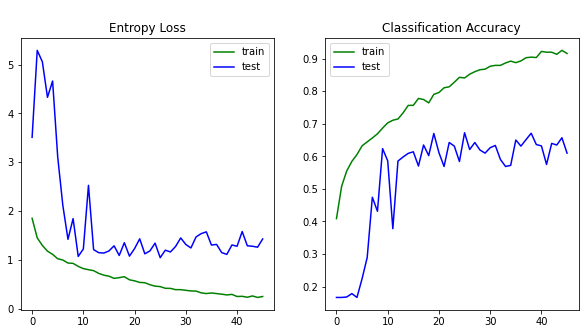

In [98]:
# Build graphs of entropy loss and accuracy
graph_accuracy_loss(history)

In [ ]:
# As we see our model with batch normalization learns much faster.
# has higher accuracy score and a bit higher overfitting on a training set
# so we are going to use this model as our best model (with data augmentation)

<h3>Model VGG16</h3>

In [ ]:
# The architecture of VGG16 was used here just for comparison of time needed to train this model

In [100]:
# Implementing Early stoping and saving chekpoints
ES = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
MC = ModelCheckpoint('best_model_vgg16.h5', monitor='val_accuracy', 
                     verbose=1, save_best_only=True, save_weights_only=False, mode='auto')
img_rows = 224
img_cols = 224

# Define VGG16 model 
def VGG16():
    model = Sequential()
    model.add(Conv2D(input_shape=(img_rows,img_cols,3),filters=64, kernel_size=(3,3),padding="same", activation="relu"))
    model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
    model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
    
    model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
    
    model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
    
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
    
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2),name='vgg16'))
   
    model.add(Flatten(name='flatten'))
    model.add(Dense(units=4096, activation="relu", name='fc1'))
    model.add(Dense(units=4096,activation="relu", name='fc2'))
    model.add(Dense(units=6, activation='softmax', name='output'))
    
    opt = SGD(lr=0.001, momentum=0.9) # Gradient descent (with momentum) optimizer.
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [102]:
# Create sets
training_set = train_datagen.flow_from_directory('train',
                                                 target_size=(img_rows, img_cols),
                                                 batch_size=batch_size,
                                                 class_mode='categorical')


test_set = test_datagen.flow_from_directory('val',
                                            target_size=(img_rows, img_cols),
                                            batch_size=batch_size, shuffle = False,
                                            class_mode='categorical')

# Define model
model_vgg = VGG16()
# Fit model
history = model_vgg.fit_generator(training_set, 
                              steps_per_epoch=len(training_set),
                              validation_data=test_set, 
                              validation_steps=len(test_set), 
                              epochs= 85, callbacks=[ES, MC])

Found 3360 images belonging to 6 classes.
Found 1440 images belonging to 6 classes.
Epoch 1/85
53/53 [==============================] - 70s 1s/step - loss: 1.7917 - accuracy: 0.1600 - val_loss: 1.7913 - val_accuracy: 0.1868

Epoch 00001: val_accuracy improved from -inf to 0.18681, saving model to best_model_vgg16.h5
Epoch 2/85
53/53 [==============================] - 59s 1s/step - loss: 1.7912 - accuracy: 0.2179 - val_loss: 1.7909 - val_accuracy: 0.1667

Epoch 00002: val_accuracy did not improve from 0.18681
Epoch 3/85
53/53 [==============================] - 59s 1s/step - loss: 1.7907 - accuracy: 0.2471 - val_loss: 1.7904 - val_accuracy: 0.2882

Epoch 00003: val_accuracy improved from 0.18681 to 0.28819, saving model to best_model_vgg16.h5
Epoch 4/85
53/53 [==============================] - 59s 1s/step - loss: 1.7903 - accuracy: 0.2576 - val_loss: 1.7898 - val_accuracy: 0.3306

Epoch 00004: val_accuracy improved from 0.28819 to 0.33056, saving model to best_model_vgg16.h5
Epoch 5/85
5

In [103]:
# Create a new model instance to upload the best saved model there
# because our trained model finished training with the final accuracy not the best possible
model = VGG16()

# Load the previously saved weights
model.load_weights('best_model_vgg16.h5')

# Evaluate model

_, acc = model.evaluate_generator(test_set, steps=len(test_set), verbose=0)
print("Best accuracy: %.4f" % (acc * 100.0))

Best accuracy: 50.6944


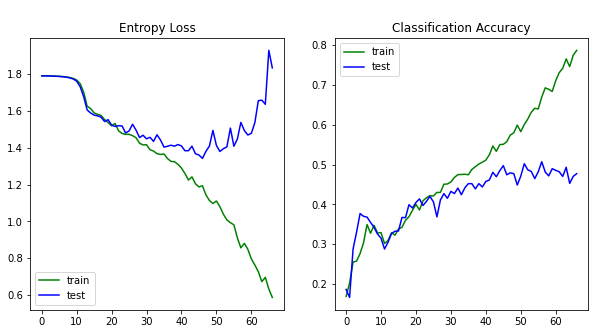

In [104]:
# Build graphs of entropy loss and accuracy
graph_accuracy_loss(history)

In [ ]:
# As we see vgg16 needs a lot of time to train and didn't achieve higher level of accuracy
# for our dataset.

# Filters

In [ ]:
# For appear always the same first picture need have 'suffle=False' in flow_from_directory

# test_set contain 1440 images and they are divided in batch_size
# 1st batch_size has 64 images
# totally exist 22 batch_size with 64 images and 1 batch_size with 32 images

(64, 224, 224, 3)
(64, 6)


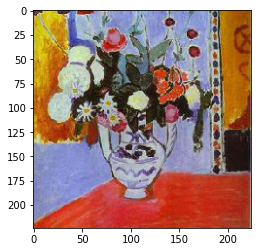

In [105]:
# Define images array
image_test = []
# Define images labels
labels_test = []
for image, label in test_set:
    image_test = image
    #(number of pictures, img_rows, img_cols, dimention)
    print(image_test.shape)
    labels_test = label
    #(number of pictures, number of artists)
    print(labels_test.shape)
    
    
    # only for show if it is working    
    plt.figure()
    plt.imshow(image[0])
    plt.grid(False)
    plt.show()
    
    break

#### All layers in subplots ploting the same number of filters 

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_147_input (InputLayer [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d_147 (Conv2D)          (None, 224, 224, 32)      896       
_________________________________________________________________
batch_normalization_35 (Batc (None, 224, 224, 32)      128       
_________________________________________________________________
conv2d_148 (Conv2D)          (None, 224, 224, 32)      9248      
_________________________________________________________________
batch_normalization_36 (Batc (None, 224, 224, 32)      128       
_________________________________________________________________
max_pooling2d_66 (MaxPooling (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_149 (Conv2D)          (None, 112, 112, 64)      18496 

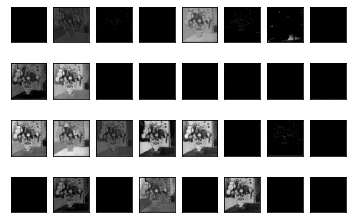

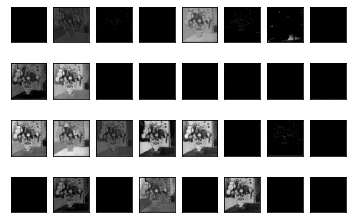

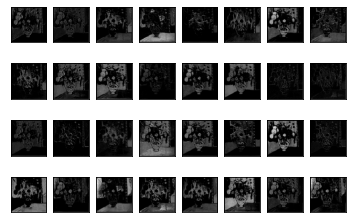

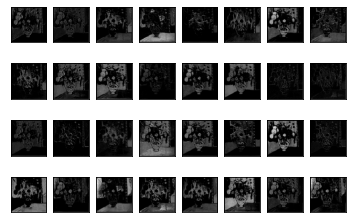

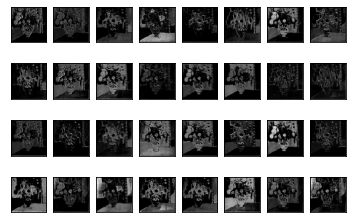

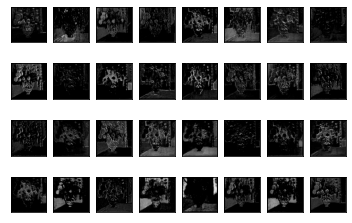

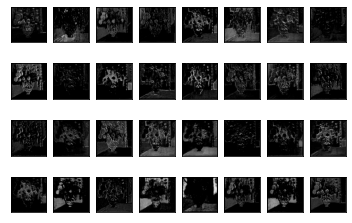

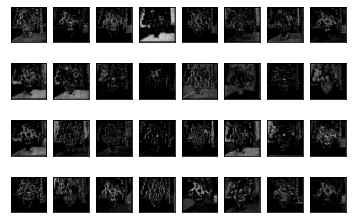

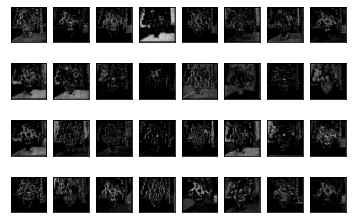

In [107]:
# Visualize feature maps output from each block in the vgg model

# load the model
model = model_bn

# show all filters
ixs = [0,1,2,3,4,5,6,7,8]
outputs = [model.layers[i].output for i in ixs]
model = Model(inputs=model.inputs, outputs=outputs)
model.summary()
# load the image with the required shape

# Define only one picture to try if it is working with image test
img = image_test[0]

# convert the image to an array
img = img_to_array(img)
# expand dimensions so that it represents a single 'sample'
img = expand_dims(img, axis=0)
# get feature map for first hidden layer
feature_maps = model.predict(img)
# plot the output from each block

# plot all 32 maps in an 4x8 squares
# as the 1st number of filters defined in the model was 32
rows = 4
cols = 8

for fmap in feature_maps:
    # plot all 32 maps in an 4x8 squares
    ix = 1
    
    for _ in range(rows):
        
        for _ in range(cols):
            # specify subplot and turn of axis
            ax = pyplot.subplot(rows, cols, ix)
            ax.set_xticks([])
            ax.set_yticks([])
            
            
            # plot filter channel in grayscale
            pyplot.imshow(fmap[0, :, :, ix-1],
                          cmap='gray'
                         )
            ix += 1

# show the figure
    pyplot.show()


#### Each layer with the number of filters that this layer has

In [108]:
# Define function
def filters(layer_number, rows, cols, picture_n):
    model = model_bn
    # redefine model to output right after the first hidden layer
    model = Model(inputs=model.inputs, outputs=model.layers[layer_number].output)
    #model.summary()
    # load the image with the required shape
    img = image_test[picture_n]
    # convert the image to an array
    img = img_to_array(img)
    # expand dimensions so that it represents a single 'sample'
    img = expand_dims(img, axis=0)
    # get feature map for first hidden layer
    feature_maps = model.predict(img)
    # plot all 64 maps in an 8x8 squares
    rows = rows
    cols = cols
    ix = 1
    for _ in range(rows):
        for _ in range(cols):
            # specify subplot and turn of axis
            ax = pyplot.subplot(rows, cols, ix)
            ax.set_xticks([])
            ax.set_yticks([])
            # plot filter channel in grayscale
            pyplot.imshow(feature_maps[0, :, :, ix-1], cmap='gray')
            ix += 1
    # show the figure
    pyplot.show()
    return

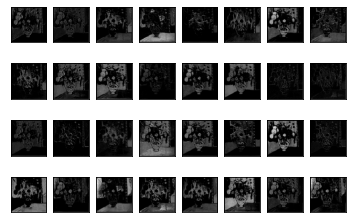

In [109]:
filters(layer_number = 2, rows = 4, cols = 8, picture_n = 0)

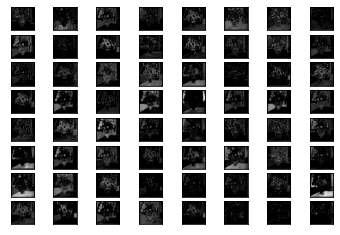

In [110]:
filters(layer_number = 5, rows = 8, cols = 8, picture_n = 0)

# Predict artist

In [113]:
predictions = model_bn.predict(image_test)
predictions[0]

array([9.9877185e-01, 8.6963679e-05, 7.7238692e-06, 5.6055892e-04,
       5.0421996e-04, 6.8726782e-05], dtype=float32)

In [114]:
# Prediction label
print(np.argmax(predictions[0]))
print(predictions[0])

# Real label
print(np.argmax(labels_test[0]))
print(labels_test[0])

0
[9.9877185e-01 8.6963679e-05 7.7238692e-06 5.6055892e-04 5.0421996e-04
 6.8726782e-05]
0
[1. 0. 0. 0. 0. 0.]


In [115]:
# autors name to add in graph below
artists_name = os.listdir('val')
artists_name

['Monet', 'Sargent', 'Renoir', 'Matisse', 'VanGogh', 'Pissaro']

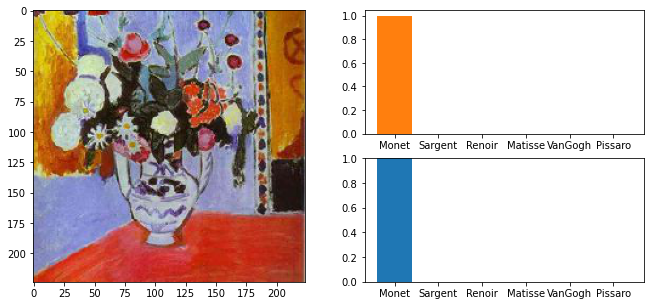

In [116]:
plt.figure(figsize=(11,5))
plt.subplot(1,2,1)

# select one picture in test
plt.imshow(image_test[0])
plt.subplot(2,2,2)
plt.bar(artists_name, labels_test[0],color = 'C1')
plt.subplot(2,2,4)
plt.bar(artists_name, predictions[0])
plt.ylim(0, 1)
plt.show()

In [19]:
! git clone https://github.com/svasylyeva/AWS

Cloning into 'AWS'...
remote: Enumerating objects: 4840, done.
remote: Counting objects: 100% (4840/4840), done.
remote: Compressing objects: 100% (4840/4840), done.
remote: Total 4840 (delta 19), reused 4812 (delta 0), pack-reused 0
Receiving objects: 100% (4840/4840), 75.17 MiB | 43.78 MiB/s, done.
Resolving deltas: 100% (19/19), done.
Checking out files: 100% (9600/9600), done.


In [20]:
cd AWS

/content/AWS/AWS


In [21]:
!ls

artists  train	val


In [10]:
rm Code_128px_35_folders_FINAL.ipynb